In [1]:
import os

def find_path(name, path='/content'):
    '''
    поиск файла или папки
    '''
    result = []
    for root, dirs, files in os.walk(path):
        if name in files+dirs:
          result.append([os.path.join(root, name), root])
    return result

if len(find_path('MyDrive')) == 0 and True:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if True:
  os.chdir(find_path('Antiviral_Drug_Discovery_with_LightFM.ipynb')[0][1])
os.getcwd()

In [ ]:
# polara and gitfiles
!pip -q install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara
! wget -q https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar5/dataprep.py -O dataprep.py
! wget -q https://raw.githubusercontent.com/Personalization-Technologies-Lab/RecSys-Course-HSE-Fall23/main/Seminar5/evaluation.py -O evaluation.py
!pip -q install lightfm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from scipy.sparse import hstack as sp_hstack
from scipy.sparse import diags as spdiags
from scipy.sparse import eye as speye

from tqdm import tqdm
from polara.preprocessing.dataframes import matrix_from_observations

from lfm import build_lfm_model, encode_virus_features
from evaluation import topn_recommendations

# Setting up Kaggle

For your convenience, we've setup Kaggle leaderboard for this home assignment. This will help you to immediately get an understanding of whether you're on the right way. If you submission gets you 0 score, something is wrong with your implementation.

To submit your solutions automatically, you need to
1. Register at the competition page. Use [this link](https://www.kaggle.com/t/4c8fd62231ce4308806b642ac6002c07) for registering.
2. Setup Kaggle API client via `pip install kaggle` into your environment.
3. Store your Kaggle API credentials locally. See [this instruction](https://github.com/Kaggle/kaggle-api#api-credentials) for details.

Before uploading the solution, convert it into the proper format and save it locally, using the following function:

In [ ]:
!pip -q install kaggle

In [ ]:
def save_submission(recs, test_user_index, item_index, name='kaggle_submission.csv'):
    """
    Saves the recommendations for test users in a CSV file in a proper format,
    ready for upload as a Kaggle submission.
    It also converts internal indices into their original external representation.

    Parameters
    ----------
    recs : numpy.ndarray
        An array of shape (num_test_users, num_recommendations) containing the
        indices of the recommended items.
    test_user_index : pd.Index
        Pandas Index containing the external test user indices.
    item_index : pd.Index
        Pandas Index containing the index mapping for the item indices.
    name : str, optional
        Name of the output file. Defaults to 'kaggle_submission.csv'.

    Returns:
        None
    """
    submission = pd.Series(
        data = list(item_index.take(recs).values),
        index = test_user_index,
        name = 'compound_id'
    ).apply(lambda x: ' '.join([str(i) for i in x])).reset_index()
    submission.to_csv(name, index=False)


After the solution is saved, you can upload it using the command in the following format:

```
!kaggle competitions submit -c {competition_name} -f {submission_file} -m 'my submision name'
```

The competition name is provided below. Do not change it.

In [ ]:
competition_name = 'anti-viral-drug-discovery-hse-recsys-course-2023'

**NOTE #1:** Kaggle only allows up to 20 submissions per day. Try to use the submissions budget wisely.  

**NOTE #2:** If you find it more convenient, you can still submit solutions manually without using the code provided above.

In [ ]:
import os
import json

kaggle_cred_file = find_path('kaggle.json')[0][0]
# Opening JSON file
with open(kaggle_cred_file) as json_file:
    data = json.load(json_file)

os.environ['KAGGLE_USERNAME'] = data['username']
os.environ['KAGGLE_KEY'] = data['key']

In [ ]:
import kaggle
kaggle.api.authenticate()

In [ ]:
!kaggle competitions download -c {competition_name}

  0% 0.00/123k [00:00<?, ?B/s]
100% 123k/123k [00:00<00:00, 17.5MB/s]


In [ ]:
!unzip {competition_name}.zip

Archive:  anti-viral-drug-discovery-hse-recsys-course-2023.zip
  inflating: virus_chem_activation.csv  
  inflating: virus_features.csv      


# Preparing Data

You will work with two sources of data:  
- activation data (`virus_chem_activation.csv`)
  - describes if there is a positive (+1) or negative (-1) response from a virus to a chemical compound
    - positive activation means that the compound is likely to be effective against the virus
    - negative activation means the the virus is chemically resistant to the compound
- virus family data (`virus_features.csv`)
  - describes which viral family class each virus belongs to


Your target viruses are listed below by their `virus_id`:

In [ ]:
cold_start_viruses = pd.Index([599, 757, 1076, 1200, 1421, 1970, 2170, 2724], name='virus_id')


Your global task:
 - for each target virus, identify top-5 compounds that might have positive activation on them.

 Note that unlike typical scenario, in this case, the target viruses must maximally dislike the recommendations. :)

## Data for binary classification? (5 pts)

Would it be possible to simply formulate the task in terms of a binary classification with  `[+1.0, -1.0]` labels ? Describe the pros and cons of such an approach? Is it applicable in the current task?

**Hint:** How many types of "feedback" do we actually have? Is it just two?

**Your answer here**
* Pros:
    * Simplicity: Binary classification is a straightforward and well-understood concept in machine learning. It simplifies the task and can be implemented using various algorithms.
    * Interpretability: The binary labels make it easier to interpret the model's predictions.
* Cons⚛:
    * Loss of Information: By using only two labels (+1.0, -1.0), we lose the granularity of the activation response. The strength or degree of the positive or negative response is not captured
    * Ignoring chemical type of reactions: Different viruses may respond differently to compounds, and some viruses might have mixed or nuanced responses.

## Load data +

In [ ]:
data = pd.read_csv('virus_chem_activation.csv')
data.tail()

,compound_id,virus_id,activated
40472,516059,3174,-1.0
40473,516063,3174,1.0
40474,573139,3174,-1.0
40475,615133,3174,-1.0
40476,1303637,3174,1.0


In [ ]:
data.groupby('activated').nunique()

,compound_id,virus_id
activated,,
-1.0,4344,88
1.0,3791,100


In [ ]:
virus_families = pd.read_csv('virus_features.csv')
virus_families.head()

,virus_id,family
0,103,1814
1,480,1882
2,481,1882
3,483,1882
4,502,1884


## Check data consistency (total 5 pts) +

### cold start setting  (2 pts) +

Recall that scientific labs were not able to identify compounds that would be effective against the target viruses.  

Veryfy that there is `no positive activation` data for these viruses in the provided dataset:

In [ ]:
data[data['activated']==-1].virus_id.unique()

array([ 103,  480,  481,  483,  502,  503,  509,  514,  518,  519,  527,
        548,  582,  596,  599,  602,  607,  608,  609,  611,  614,  615,
        619,  621,  692,  698,  706,  707,  708,  711,  757,  762,  763,
        764,  771,  772,  776,  919, 1076, 1077, 1187, 1188, 1200, 1203,
       1359, 1380, 1418, 1419, 1421, 1577, 1583, 1615, 1617, 1620, 1624,
       1965, 1969, 1970, 2168, 2169, 2170, 2189, 2476, 2486, 2724, 2725,
       2726, 2728, 2732, 2733, 2836, 2891, 2898, 2902, 2911, 2926, 2927,
       2928, 2937, 2938, 2939, 2941, 2942, 2965, 2983, 2984, 2989, 3174])

In [ ]:
# your code here:
#virus_with_neg = data[data['activated']==-1].virus_id.unique()
# we need to search this for cold start viruses
cold_viruses_data = data[data['virus_id'].isin(cold_start_viruses)]
assert cold_viruses_data.groupby('virus_id').agg({'activated': lambda a: len(set(a))})['activated'].unique().size == 1

### lack of features (3 pts) +

Recall that despite the joint attempts of many scientits, only general families of the new viruses were identified. These families may not be necessarily associated with compounds that give positive activations against the viruses of the family.

Verify this by calculating the proportion of families of target viruses among all families associated with positive activation against at least one compound.

In [ ]:
# your code here
#на те семьи против которых есть хотя бы одно лекарство/кол-во семей таргет вирусов
data_f = data.merge(virus_families,on='virus_id')
familes_of_target_viruses = virus_families[virus_families.virus_id.isin(cold_start_viruses)].family.unique()
print(familes_of_target_viruses)

[1912 1947 2006 2024 2054 2099 2143 2236]


In [ ]:
family_activated = data_f[data_f['family'].isin(familes_of_target_viruses)].groupby('family').agg({'activated': lambda a: len(set(a))})
family_activated

,activated
family,
1912,1
1947,1
2006,2
2024,2
2054,2
2099,2
2143,1
2236,1


In [ ]:
proportion = (family_activated.activated.to_numpy()-1).sum() / len(family_activated.activated)
print(f'Proportion of virus families wich have positive activations = {proportion}')

Proportion of virus families wich have positive activations = 0.5


## Feature pre-processing (total 5 pts)

- Your task now is to design a proper hybrid recommender for the cold start setting considering all the features that you were provided with. The solution will be based on the [`LightFM`](https://github.com/lyst/lightfm/) approach.

- As you have already verified, the `virus family` feature is not sufficient for the task, as it is not fully covered by the positive activation data. Some additional information must be used.

Before proceeding, try to pause here and think what esle can be used as an additional feature?  
- **Hint #1**: Recall NSVD or SVD++ models. What were the design matrices composed of in their case?
- **Hint #2**: How many types of interactions are there in the activation data?

### resistance feature

Let's denote the ability of viruses to remain intact under action of chemical comounds as `resistance`.

This type of information corresponds to the `activated == -1.0` values in the provided activation dataset. You have probably already guessed that this is exactly the type of feature that you can additionally use in construction of a hybrid recommender.

- Prepare the `resistance feature` dataset by taking out the corresponding entries from the activation dataset.
- Store the data in the `resistance` dataframe.
- Put the positive activation data into a separate `train_data` dataframe. This dataframe will be used for training.

#### extracting additional feature data (1 pts) +

In [ ]:
# your code here:
resistance =  data[data.activated==-1]

In [ ]:
resistance.nunique()

compound_id    4344
virus_id         88
activated         1
dtype: int64

#### extracting training data (1 pts) +

In [ ]:
# your code
train_data = data[data.activated==1]

It's a good idea to immediately transform the training data into a convenient sparse format and to build the corresponding index of viruses and compounds. You did it several times throughout the course already. Below is an example of how it can be achieved with the `matrix_from_observations` function form `polara`. No additional code is required here.

In [ ]:
train_matrix, virus_index, compound_index = matrix_from_observations(
    train_data, userid='virus_id', itemid='compound_id'
)
train_matrix

<100x3791 sparse matrix of type '<class 'numpy.int64'>'
	with 20105 stored elements in Compressed Sparse Row format>

In [ ]:
len(virus_index), len(compound_index)

(100, 3791)

### transforming features into proper format (3 pts)

According to the LightFM documentation, features must be represented in the format of `sparse matrices` with
- rows corresponding to an entity the feature describes and
- columns corresponding to the feature values.

You are provided with the convenience function named `encode_virus_features` which takes as an input:
- a virus feature dataframe,
- an array of viruses (in the form of `pandas Index`) which features are to be encoded
- the name of the columns corresponding to the selected feature type

and returns
- a sparse binary feature matrix (one-hot encoding of features) and
- the corresponding feature index that maps columns of the matrix back into the original features of viruses from the training.

The feature index will be later used for preprocessing the features of the target viruses.

#### resistance into sparse format

In [ ]:
resistance.head()

,compound_id,virus_id,activated
0,24630,103,-1.0
1,451356,103,-1.0
2,525524,103,-1.0
3,525528,103,-1.0
4,541277,103,-1.0


In [ ]:
# your code here:
virus_strength_feature_matrix, virus_strength_feature_idx = encode_virus_features(
     resistance, virus_index, 'compound_id'
)
virus_strength_feature_matrix.shape

(100, 4313)

In [ ]:
assert virus_strength_feature_matrix.shape[0] == len(virus_index)

#### virus family into sparse format

Do the same transformation for the `virus family` feature below:

In [ ]:
virus_families.head()

,virus_id,family
0,103,1814
1,480,1882
2,481,1882
3,483,1882
4,502,1884


In [ ]:
# your code here:
virus_family_feature_matrix, virus_family_feature_idx = encode_virus_features(
    virus_families, virus_index, 'family'
)
virus_family_feature_matrix.shape

(100, 44)

In [ ]:
assert virus_family_feature_matrix.shape[0] == len(virus_index)

## Transform target viruses' features into sparse format (total 2 pts)

You also need to perform the corresponding transformation of features for the target viruses that are not part of the train by construction.

- Recall that not all target viruses have their `family` feature represented in the train data. The same holds for the `resistance` feature as well.
- The `encode_virus_features` takes care of that by filtering out the non-consistent features that cannot be a part of the training.
- To make it work you just need to provide the proper index of the features obtained at the earlier steps of the feature transformation:
  - the index must be provided via an optional argument `feature_index` (must be of `pandas Index` type),
  - mind that all features that are not covered by the provided feature index must be discarded (controlled by the `drop_invalid` argument, `True` by default)

### resistance (1 pts)

In [ ]:
# fill in the missing parts of the code:
virus_cold_start_strength_feature_matrix, virus_cold_start_strength_feature_idx = encode_virus_features(
    resistance,
    cold_start_viruses,
    'compound_id',
    feature_index = virus_strength_feature_idx, # provide the proper feature index
    drop_invalid = True  # filter out features inconsistent with train data
)
virus_cold_start_strength_feature_matrix.shape

(8, 4313)

### family (1 pts)

In [ ]:
# fill in the missing parts of the code:
virus_cold_start_family_feature_matrix, virus_cold_start_family_feature_idx = encode_virus_features(
    virus_families,
    cold_start_viruses,
    'family',
    feature_index = virus_family_feature_idx, # provide the proper feature index
    drop_invalid = True  # filter out features inconsistent with train data
)
virus_cold_start_family_feature_matrix.shape

(8, 44)

# Building the hybrid recommender model

Your task is to gradually improve the model following the instructions provided below.

## Initial setup for LightFM

### data description

In [ ]:
data_description = dict(
    users = 'virus_id',
    items = 'compound_id',
    n_users = len(virus_index),
    n_items = len(compound_index),
    # user_features = ... skip for now, will be defined later
    item_features = None # compound features are not present in the dataset
)
data_description

{'users': 'virus_id',
 'items': 'compound_id',
 'n_users': 100,
 'n_items': 3791,
 'item_features': None}

You will use a separate data description dictionary for generating predictions. This dictionary will provide the necessary information about the target viruses.

In [ ]:
data_description_cold_start = dict(
    users = 'virus_id',
    items = 'compound_id',
    n_cold_users = len(cold_start_viruses),
    n_items = len(compound_index),
    # user_features = ... skip for now, will be defined later
    item_features = None # compound features are not present in the dataset
)
data_description_cold_start

{'users': 'virus_id',
 'items': 'compound_id',
 'n_cold_users': 8,
 'n_items': 3791,
 'item_features': None}

### hyper-parameters

In [ ]:
lfm_config = dict(
    no_components = 60,
    loss = 'warp',
    max_sampled = 1,
    max_epochs = 60,
    learning_schedule = 'adagrad',
    user_alpha = 1e-3,
    item_alpha = 1e-3,
    random_state = 7032023
)

### evaluation

In [ ]:
topn = 5

## The simplest case - using the "family" feature (total 10 pts)

### training

In [ ]:
data_description['user_features'] = virus_family_feature_matrix

In [ ]:
lfm_model = build_lfm_model(
    lfm_config,
    train_matrix,
    data_description,
    iterator = tqdm
)

100%|██████████| 60/60 [00:01<00:00, 39.85it/s]


### generating predictions

#### Implement scoring function (10 pts)

In [ ]:
data_description_cold_start

{'users': 'virus_id',
 'items': 'compound_id',
 'n_cold_users': 8,
 'n_items': 3791,
 'item_features': None}

In [ ]:
def lightfm_scoring(model, data, data_description):
    """
    A standard scoring function adopted for use with LightFM in the user cold-start settings.
    """
    dtype = 'i4'
    all_users = np.arange(data_description['n_users']).astype(dtype)
    test_items = data_description['cold_items'].astype(dtype)
    item_index, user_index = np.meshgrid(test_items, all_users, copy=False)

    lfm_scores = model.predict(
        user_index.ravel(),
        item_index.ravel(),
        user_features = data_description['user_features'],
        item_features = data_description['item_features'],
    )
    scores = lfm_scores.reshape(len(test_items), len(all_users), order='F')
    return scores

In [ ]:
def lightfm_scoring_base(model, data, data_description):
    """
    A standard scoring function adopted for use with LightFM in the user cold-start settings.
    """
    dtype = 'i4'
    all_items = np.arange(data_description['n_items'], dtype=dtype) # our compounds
    test_users = np.arange(data_description['n_cold_users'], dtype=dtype) # cold viruses
    item_index, user_index = np.meshgrid(all_items, test_users, copy=False)

    lfm_scores = model.predict(
        user_index.ravel(),
        item_index.ravel(),
        user_features = data_description['user_features']
    )
    scores = lfm_scores.reshape(len(test_users), len(all_items))
    return scores

Use `data_description_cold_start` dictionary to initialize the required variables.

In [ ]:
data_description_cold_start['user_features'] = virus_cold_start_family_feature_matrix

In [ ]:
data_description_cold_start

{'users': 'virus_id',
 'items': 'compound_id',
 'n_cold_users': 8,
 'n_items': 3791,
 'item_features': None,
 'user_features': <8x44 sparse matrix of type '<class 'numpy.float64'>'
 	with 4 stored elements in Compressed Sparse Row format>}

In [ ]:
lfm_scores = lightfm_scoring_base(lfm_model, None, data_description_cold_start)
lfm_recs = topn_recommendations(lfm_scores, topn=topn)

In [ ]:
lfm_recs

array([[ 294,  211,  920,  989, 2678],
       [ 294,  211,  920,  989, 2678],
       [  98,   87,  270, 3711,   96],
       [3388, 3719, 1076, 1638, 2685],
       [ 989, 3711, 3712,  969, 3715],
       [ 101,  102,   12,  220,   41],
       [ 294,  211,  920,  989, 2678],
       [ 294,  211,  920,  989, 2678]])

#### Evaluate the result using Kaggle

In [ ]:
kaggle_submission_name = 'base_model.csv'

save_submission(
    lfm_recs, cold_start_viruses, compound_index, name=kaggle_submission_name
)

In [ ]:
#!kaggle competitions submit -c {competition_name} -f {kaggle_submission_name} -m "base model ver.1"

Please also report the obtained score on the Kaggle leaderboard here.

### handling biases (total 13 pts)

It is perhaps reasonable to assume that most popular and effective compounds are known to scientists and most likely have been tried out in the first place with the new viruses. As there's still no positive activation data, it means that the predictive model must avoid favoring popular compounds in recommendations.

Recall that, in the `LightFM` model, the major popularity biases are captured in the linear bias terms. Also note that:
- when measured across different items, the variance of the bias prediction term $\operatorname{Var}_y\left[b^\top y\right]$ can be higher than the variance of the factorization term $\operatorname{Var}_y\left[x^\top PQ^\top y\right]$
  - if this is the case, the difference in predicted scores related to the factorization term may become negligible and won't affect ranking of the items;
  - in other words, the recommendations of your model may promote items with the highest bias values and provide little to no personalization.
- Unfortunately, `LightFM` neither lets you to disable biases nor does it provide a separate regularisation coefficient for linear biases (so that their influence could be decreased).
- Hence, you will use a simple heuristic - just set biases to 0 when generating prediction scores


**The task**:
- implement scoring function that allows disabling linear bias terms for items. (10 pts)
  - implement a new variant of the scoring function that takes an additional **boolean** argument `item_bias` as input
    - if `item_bias` is `False`, the function must temporarily set the corresponding bias terms to 0 when computng prediction scores
  - you can access `LightFM`'s biases array via `model.item_biases` variable (see [documentation](https://making.lyst.com/lightfm/docs/lightfm.html))
    - make sure to store the current values of biases in a temporary array using the `numpy`'s `.copy()` function
    - set all item bias weights to zero via an inplace operation `*= 0`
  - don't forget to restore biases once the the prediction scores are generated;:
    - use the `model.item_biases[:] = ...` syntax to make sure you're not creating a new varibale

You are only required to handle biases related to compounds.  
- Explain, why the linear bias term related to viruses do not play any role in the task? (3 pts)

In [ ]:
# your code here
def lightfm_scoring(model, data, data_description, item_bias=True):
    dtype = 'i4'
    all_items = np.arange(data_description['n_items'], dtype=dtype) # our compounds
    test_users = np.arange(data_description['n_cold_users'], dtype=dtype) # cold viruses
    item_index, user_index = np.meshgrid(all_items, test_users, copy=False)

    original_item_biases = model.item_biases.copy()
    if not item_bias:
        model.item_biases*= 0

    lfm_scores = model.predict(
        user_index.ravel(),
        item_index.ravel(),
        user_features = data_description['user_features']
    )
    scores = lfm_scores.reshape(len(test_users), len(all_items))

    # Restore biases once the prediction scores are generated
    model.item_biases[:] = original_item_biases
    return scores

#### regenerating scores with disabled biases

In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, data_description_cold_start, item_bias=False)
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
lfm_recs

array([[1263, 1260, 1262, 1264, 3790],
       [1263, 1260, 1262, 1264, 3790],
       [  98,   87, 2129,  253,  268],
       [3719, 1076, 3716, 1638, 3718],
       [3715, 3760, 3710, 3759,  989],
       [ 101,   41,  223,   39,   33],
       [1263, 1260, 1262, 1264, 3790],
       [1263, 1260, 1262, 1264, 3790]])

#### evaluate the result using Kaggle

In [ ]:
kaggle_submission_name = 'debiased_model.csv'

save_submission(
    lfm_recs, cold_start_viruses, compound_index, name=kaggle_submission_name
)

In [ ]:
#!kaggle competitions submit -c {competition_name} -f {kaggle_submission_name} -m "debiased model ver.1"

Please also report the obtained score on the Kaggle leaderboard here.

Was the hypothesis about the influence of bias terms confirmed?

## Improved model (total 10 pts)

Note that so far you have not implemented a truly hybrid model:
- By default, `LightFM` utilizes information about user and item `id`'s only when no feature matrices are provided (unless you use the `lightfm.data.Dataset` class, see [documentation](https://making.lyst.com/lightfm/docs/lightfm.html)).
- In the current setup, with explicitly provided `virus family` feature matrix, `LightFM` does not automatically extend the feature space with the `id`'s of the viruses.

Hence, the collaborative information is not yet utilized in the best possible way:
- a virus is simply represented as a bag of features.
- Recall that several viruses can belong to the same family.
  - Hence, the **expressiveness of the current virus representation is limited**.

The task: (5 pts)
- In order to resolve this issue, you need to manually extend representation of viruses by adding one-hot encoding of their `id`'s into the feature matrix.
- You can use functions called `eye` and `hstack` from `scipy.sparse`.
  - These functions are already imported in this notebook and accessible via the names `speye` and `sp_hstack`.

In [ ]:
import scipy
# your code here
data_description['user_features'] = sp_hstack(
    (speye(virus_family_feature_matrix.shape[0]),
    virus_family_feature_matrix)
)
data_description['user_features']

<100x144 sparse matrix of type '<class 'numpy.float64'>'
	with 200 stored elements in COOrdinate format>

### retrain the extended model

In [ ]:
lfm_model = build_lfm_model(
    lfm_config,
    train_matrix,
    data_description,
    iterator = tqdm
)

100%|██████████| 60/60 [00:00<00:00, 64.40it/s]


### generate recommendations (5 pts)

You also need to update the representation for the target viruses.

- Note that there is no `id` feature for the target viruses in the model because they are not part of the training data.
- Hence, you simply need to add an empty block of the proper shape to conform with the extended feature space.
    - Use `csr_matrix` constructor to generate an empty matrix of conforming size

In [ ]:
# your code here
data_description_cold_start['user_features'] = sp_hstack(
    (csr_matrix((virus_cold_start_family_feature_matrix.shape[0], virus_family_feature_matrix.shape[0])),
     virus_cold_start_family_feature_matrix)
)
data_description_cold_start['user_features']

<8x144 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, data_description_cold_start, item_bias=False)
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
lfm_recs

array([[1263, 1260, 1262, 1264, 3790],
       [1263, 1260, 1262, 1264, 3790],
       [ 269,   95,   12,  115,   28],
       [2755, 1094, 3558, 3720, 1948],
       [3712, 3760, 3765, 3758, 3763],
       [ 220,   46,   89,   76,  277],
       [1263, 1260, 1262, 1264, 3790],
       [1263, 1260, 1262, 1264, 3790]])

### evaluate the result using Kaggle

In [ ]:
kaggle_submission_name = 'improved_model.csv'

save_submission(
    lfm_recs, cold_start_viruses, compound_index, name=kaggle_submission_name
)

In [ ]:
#!kaggle competitions submit -c {competition_name} -f {kaggle_submission_name} -m "improved model ver.1"

Please report the obtained score on the Kaggle leaderboard here.

- Were you able to improve the metric?
- How does enabling/disabling item biases affect the result?

## Including the virus resistance feature (total 15 pts)

Following the same steps as before, construct an extended representation of virus features that utilizes of three types of information:
- collaborative
- virus family features
- virus resistance against compounds


Note that each virus may have been testsed against several different compounds with negative activation result.
- Hence, the two types of features -- `family` and `resistance` -- will have an unequal contribution into the feature representation.
- The `resistance` feature will dominate for viruses with a lot of experimental data.

Your task now is not only to extend the feature space but also to properly normalize the `resistance` feature so that its contribution becomes comparable to that of the `family` feature.

### extending feature space with the normalized resistance feature

You need to perform two steps:
- Implement a simple feature normalization function that will normalize each row in a feature matrix by the number of non-zero elements in this row.
  - You can use `diags` function from `scipy.sparse` for weights. It is already imported in the notebook under the name `spdiags`.
- Apply the function to the `resistance` feature matrix before extending the feature space. (5 pts)

In [ ]:
def normalize_features(feature_matrix):
    '''
    Normalize the input sparse binary feature matrix for every row.

    Parameters
    ----------
    feature_matrix : scipy.sparse.csr_matrix
        The input feature matrix, where each row is a binary feature vector.

    Returns
    -------
    scipy.sparse.csr_matrix
        The normalized feature matrix, where each row is a probability distribution
        over the features.

    Examples
    --------
    For a feature matrix (take A as a sparse matrix) A= [[1, 0, 1], [0, 0, 1], [1, 1, 1]],
    the normalized feature matrix is [[0.5, 0, 0.5], [0, 0, 1], [0.333, 0.333, 0.333]].

    Take into account that this function takes and returns sparse matrices.
    Dense matrices are used here for the sake of example.
    >>> A = np.array([[1, 0, 1], [0, 0, 1], [1, 1, 1]])
    >>> normalize_features(spdiags(A).tocsr())
    array([[0.5  , 0.   , 0.5  ],
           [0.   , 0.   , 1.   ],
           [0.333, 0.333, 0.333]])

    Notes
    -----
    The normalization is performed by dividing each row by the sum of its non-zero
    elements. If a row has all zeros, it is left unchanged.
    '''
    # your code here
    weights = 1.0 /np.maximum(feature_matrix.sum(axis=1), 1)

    return spdiags(weights.A.ravel()).dot(feature_matrix)

Use the `normalize_features` function that you implemented to get the extended feature representation that includes all three type of information: (10 pts)
- colaborative
- feature family
- resistance

In [ ]:
 normalize_features(virus_cold_start_strength_feature_matrix)

<8x4313 sparse matrix of type '<class 'numpy.float64'>'
	with 77 stored elements in Compressed Sparse Row format>

In [ ]:
# your code here
data_description['user_features'] = sp_hstack(
    (speye(virus_family_feature_matrix.shape[0]),
     virus_family_feature_matrix,
     normalize_features(virus_strength_feature_matrix)))

data_description_cold_start['user_features'] = sp_hstack(
    (csr_matrix((virus_cold_start_family_feature_matrix.shape[0], virus_family_feature_matrix.shape[0])),
     virus_cold_start_family_feature_matrix,
     normalize_features(virus_cold_start_strength_feature_matrix)))

### generate recommendations

In [ ]:
lfm_model = build_lfm_model(
    lfm_config,
    train_matrix,
    data_description,
    iterator = tqdm
)

100%|██████████| 60/60 [01:27<00:00,  1.45s/it]


In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, data_description_cold_start, item_bias=True)
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
lfm_recs

array([[ 272,  989, 1838,  267,   49],
       [ 272,  989,  920,   49,  267],
       [2129,  989,  326,   98,  270],
       [ 965, 2688, 3658, 3720, 3717],
       [ 989, 3757, 3695,  271, 3756],
       [  89,   46,  101,  102,   70],
       [3590,  989, 2551, 1565, 3005],
       [ 272,  920, 3456,   49,  449]])

### evaluate the result using Kaggle

In [ ]:
kaggle_submission_name = 'all_features_model.csv'

save_submission(
    lfm_recs, cold_start_viruses, compound_index, name=kaggle_submission_name
)

In [ ]:
#!kaggle competitions submit -c {competition_name} -f {kaggle_submission_name} -m "all features model ver.1"

Please report the obtained score on the Kaggle leaderboard here.

- Were you able to improve the metric?

Before proceeding, try to explain why you obtained this result after modifying the feature space.

## Relative feature weighting (total 10 pts)

Note that once all three types of features are added, their relative contribution uniformly decreases.
- In the beginning, you had collaborative and `family` features, so their relative contribution was one half.
- With extended representation the contribution is one third for each type.

Hypothesis:
- Reducing the relative contribution of collaborative part is likely to be the cause of the quality drop.

The task:
- Implement additional reweighting so that the contribution of collaborative part is one half again.
- The distribution of relative contribution weights between the `family` and the `resistance` feature must be controlled via an additional scalar hyper-parameter $\alpha \in [0, 1]$, i.e.,
  - all the `family` features must be globally multiplied by $\alpha$,
  - all the `resistance` features must be globally multiplied by $1-\alpha$.
    - That way, the scenario with only collaborative and `family` features is covered by setting $\alpha=1$.
    - Likewise, excluding `family` feature will correspond to $\alpha=0$.

In [ ]:
family_feature_weight = 0.4 # the alpha hyper-parameter

Define the reweightend feature space using the `family_feature_weight` value: (10 pts)

In [ ]:
# your code here
data_description['user_features'] = sp_hstack(
    (speye(virus_family_feature_matrix.shape[0]),
     virus_family_feature_matrix * family_feature_weight,
     normalize_features(virus_strength_feature_matrix)*(1-family_feature_weight)))

data_description_cold_start['user_features'] = sp_hstack(
    (csr_matrix((virus_cold_start_family_feature_matrix.shape[0], virus_family_feature_matrix.shape[0])),
     virus_cold_start_family_feature_matrix * family_feature_weight,
     normalize_features(virus_cold_start_strength_feature_matrix)*(1-family_feature_weight)))

### generate recommendations

In [ ]:
lfm_model = build_lfm_model(
    lfm_config,
    train_matrix,
    data_description,
    iterator = tqdm
)

100%|██████████| 60/60 [00:57<00:00,  1.04it/s]


In [ ]:
lfm_scores = lightfm_scoring(lfm_model, None, data_description_cold_start, item_bias=False)
lfm_recs = topn_recommendations(lfm_scores, topn=topn)
lfm_recs

array([[3676, 3680, 3765, 3675, 3678],
       [ 275,  116,  262,  250,   95],
       [2129,  989,  275,   89,  532],
       [ 661, 3717, 1268, 1731, 3720],
       [3760, 3712, 3759, 3762, 3763],
       [  89,  115,  220,  101,  278],
       [3699, 3679, 3394, 3698, 3702],
       [ 607, 1617, 3231, 3555,  877]])

### evaluate the result using Kaggle

In [ ]:
kaggle_submission_name = 'reweighted_features_model.csv'

save_submission(
    lfm_recs, cold_start_viruses, compound_index, name=kaggle_submission_name
)

In [ ]:
#!kaggle competitions submit -c {competition_name} -f {kaggle_submission_name} -m "reweighted features model ver.1"

100% 345/345 [00:00<00:00, 1.09kB/s]
Successfully submitted to Anti-viral drug discovery - HSE RecSys course 2023

Please report the obtained score on the Kaggle leaderboard here. (5 pts)

- Were you able to improve the metric?
- Was the hypothesis confirmed?

Yes, I can improve the metric. Hypothesis was confirmed

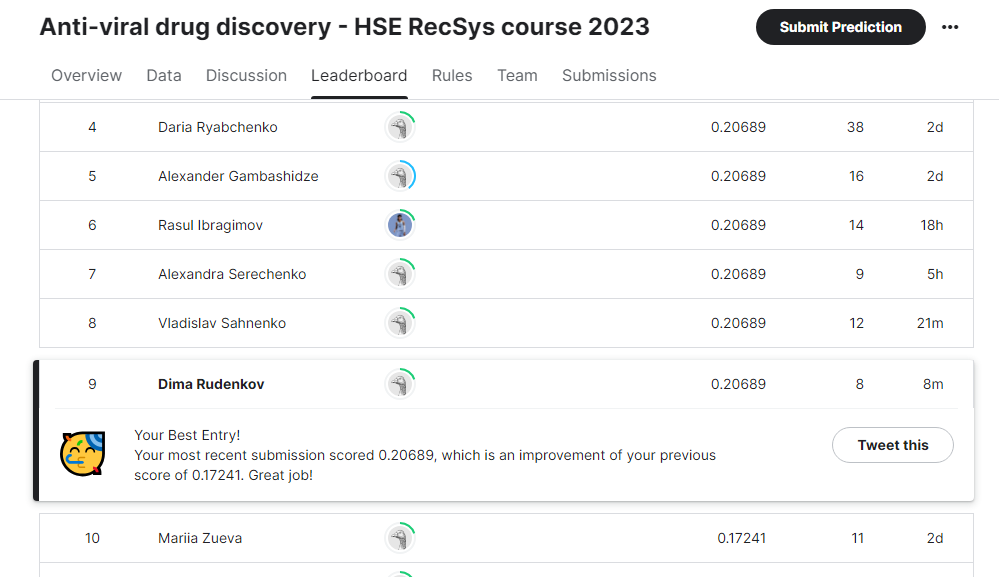